# Road segmentation unet

In [1]:
#Import Tensor flow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [2]:
#Import utils libraries and functions
import os
import matplotlib.image as mpimg
import numpy
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
#Import pix2pix used for the upsampler
from tensorflow_examples.models.pix2pix import pix2pix

## Load the dataset

In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1
  return input_image, input_mask

In [6]:
@tf.function
def load_image_train(image, mask):
  input_image = tf.image.resize(image, (128, 128))
  input_mask = tf.image.resize(mask, (128, 128))

    
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
    
  #input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
"""
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask
"""

"\ndef load_image_test(datapoint):\n  input_image = tf.image.resize(datapoint['image'], (128, 128))\n  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))\n\n  input_image, input_mask = normalize(input_image, input_mask)\n\n  return input_image, input_mask\n"

In [8]:
TOTAL_LENGTH = 100
TRAIN_LENGTH = 70
VALIDATION_LENGTH = 30
BATCH_SIZE = 1
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
IMG_HEIGHT = 400
IMG_WIDTH = 400


In [9]:
list_ds = tf.data.Dataset.list_files('training/images/*')
for f in list_ds.take(5):
  print(f.numpy())

b'training/images/satImage_057.png'
b'training/images/satImage_074.png'
b'training/images/satImage_016.png'
b'training/images/satImage_045.png'
b'training/images/satImage_037.png'


In [10]:
def decode_img(img, chan):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=chan)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def get_label(file_path):
  mask_path = tf.strings.regex_replace(file_path, 'images', 'groundtruth')
  img = tf.io.read_file(mask_path)
  img = decode_img(img,1)
  return img

def process_path(file_path):
  #label = get_label(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img,3)
  return img, label


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [13]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)


Image shape:  (400, 400, 3)
Label:  (400, 400, 1)


In [14]:
dataset = labeled_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = dataset.take(TRAIN_LENGTH)
test = dataset.skip(TRAIN_LENGTH)
#test = dataset['test'].map(load_image_test)

In [15]:
labeled_ds

<DatasetV1Adapter shapes: ((400, 400, 3), (400, 400, 1)), types: (tf.float32, tf.float32)>

In [16]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [17]:
train_dataset

<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

Let's take a look at an image example and it's correponding mask from the dataset.

In [18]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

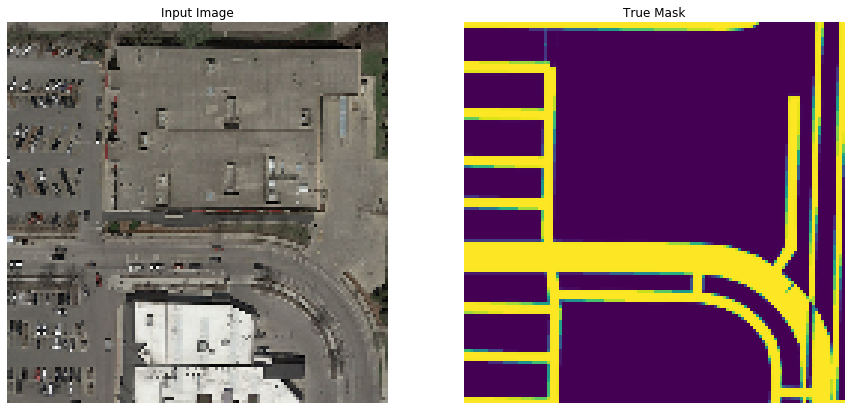

In [19]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [20]:
OUTPUT_CHANNELS = 2

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [21]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = True

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [22]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [23]:
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is losses.sparse_categorical_crossentropy. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and losses.sparse_categorical_crossentropy is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [24]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

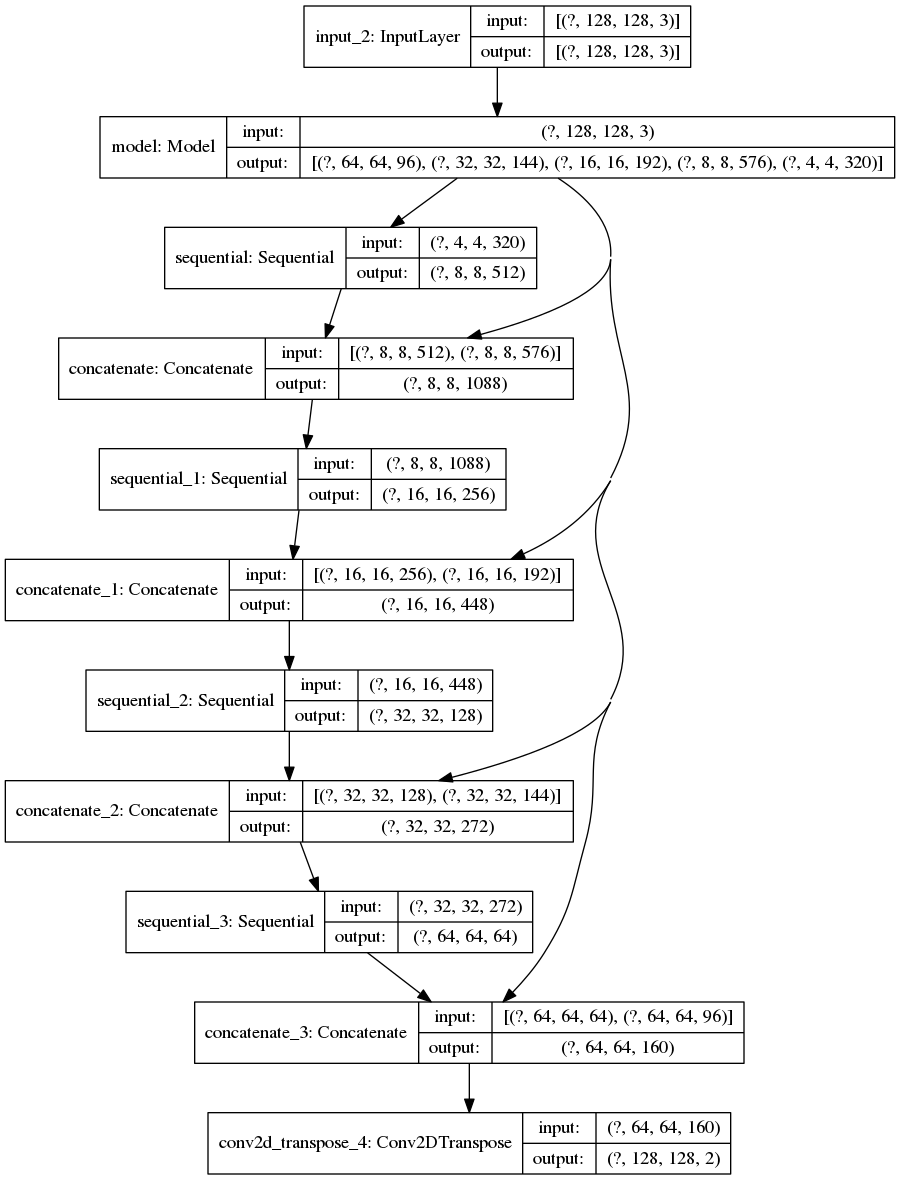

In [25]:
# To fix execution/installation problem
# https://stackoverflow.com/questions/36886711/keras-runtimeerror-failed-to-import-pydot-after-installing-graphviz-and-pyd
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

In [26]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [27]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

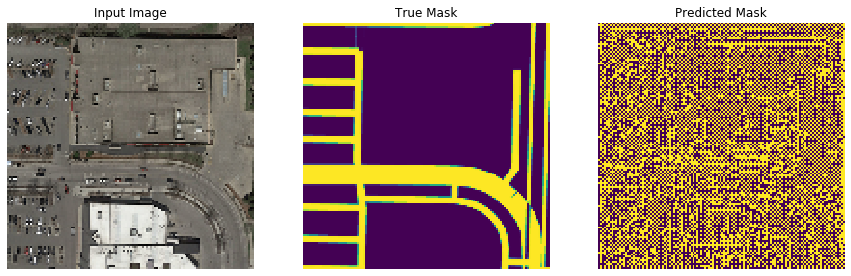

In [28]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [29]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

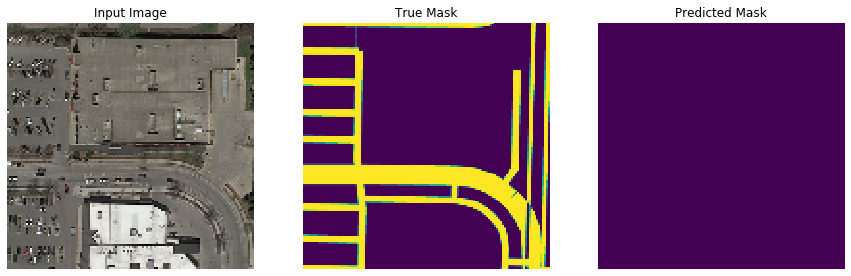


Sample Prediction after epoch 20

70/70 [==============================] - 6s 93ms/step - loss: 2.1766e-05 - accuracy: 0.7503 - val_loss: 2.6792e-05 - val_accuracy: 0.7526


In [30]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VALIDATION_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

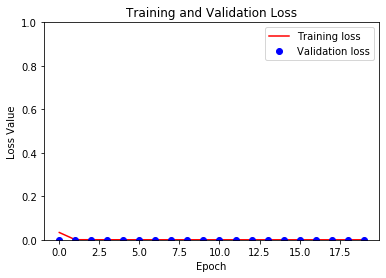

In [31]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

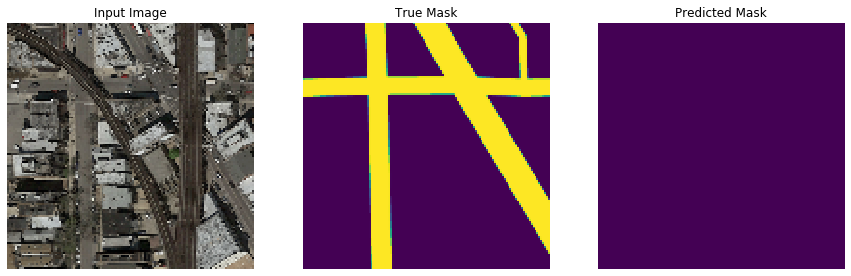

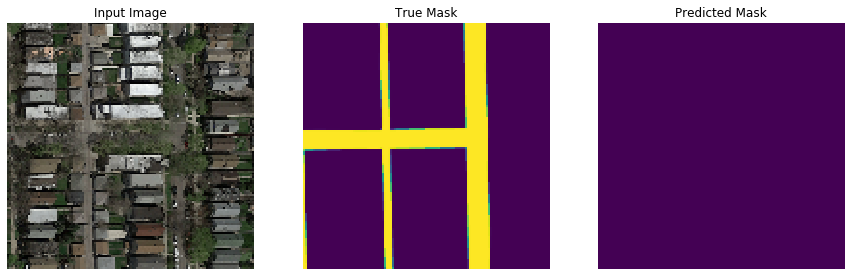

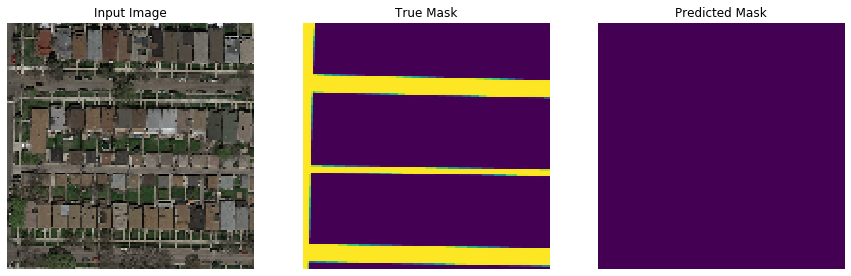

In [32]:
show_predictions(test_dataset, 3)

## Next steps
Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained model. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) for another model you can retrain on your own data.